# Assignment 8: Correlation Analysis and Hypothesis Testing

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and hypothesis testing, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

**Correlation Analysis**
1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 


**Hypothesis Testing**
1. Why A/B testing?  
2. What is a permutation test? How to implement it?
3. What is p-value? How to avoid p-hacking? 
4. What is a chi-squared test? How to implement it?


In this assignment, you can use [pandas](https://pandas.pydata.org/) or PySpark to manipulate data, and use [matplotlib](https://matplotlib.org/) or [seaborn](seaborn.pydata.org) to make plots. 

## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a dataset from [property_tax_report_2018.zip](property_tax_report_2018.zip). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2018.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [1]:
import pandas as pd

df = pd.read_csv("property_tax_report_2018.csv")

df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE']+x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose <font color='blue'>postcode starts with 'V6A'</font>. Furthermore, we remove the houses that were <font color='blue'>built before 1900</font>.

<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

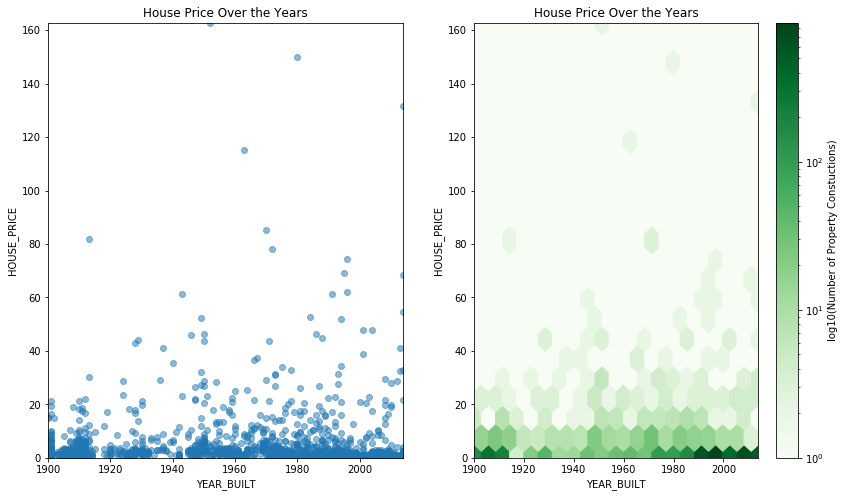

In [3]:
#<-- Write Your Code -->
import matplotlib.pyplot as plt

filter_df = df.loc[df.PROPERTY_POSTAL_CODE.str.startswith("V6A") & (df['YEAR_BUILT'] >= 1900.0)]  #consider the area code starts with V6A
X = filter_df['YEAR_BUILT']
Y = filter_df['HOUSE_PRICE']

#defining the axis for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))

# draw the scatter plot
ax1.scatter(X, Y, alpha=0.5)
ax1.set_xlabel('YEAR_BUILT')
ax1.set_ylabel('HOUSE_PRICE')
ax1.set_title('House Price Over the Years')
ax1.axis([X.min(),X.max(),Y.min(), Y.max()])

# draw the hexbin plot
hexb = ax2.hexbin(X, Y, gridsize = 20, bins = 'log', cmap=plt.cm.Greens)
ax2.set_title('House Price Over the Years')
ax2.set_xlabel('YEAR_BUILT')
ax2.set_ylabel('HOUSE_PRICE')
ax2.axis([X.min(),X.max(),Y.min(), Y.max()])
# setting the colorbar scale
clr_bar = fig.colorbar(hexb, ax =ax2)
clr_bar.set_label('log10(Number of Property Constuctions)')

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. From scatterplot(left side subplot), it can be clearly seen that there are very less number of property constructions with house price ranges above 80.
2. In Hexbin plot, color concentration level is telling us the number of property consturcted. So, from above hexbin plot, we can say that the most number of properties have been consturcted around years 1900 and 2000.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insight. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


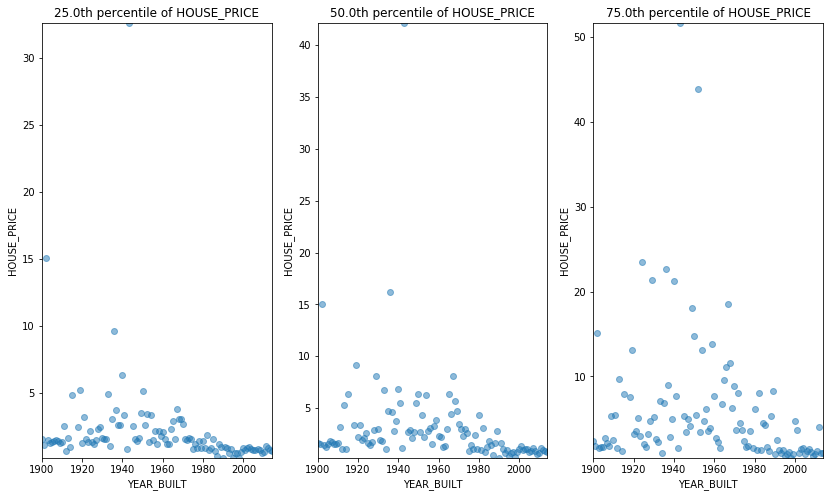

In [4]:
# quantiles array
quantiles_arr = [.25, .5, .75]
newdf = filter_df[['HOUSE_PRICE', 'YEAR_BUILT']]
percentile_df = newdf.groupby('YEAR_BUILT').quantile(quantiles_arr, numeric_only=False).reset_index()
fig, axes = plt.subplots(1, 3 ,figsize=(14,8))

# scatter plot for each quantile
i = 0
for quants in quantiles_arr:
    quant_df = percentile_df[(percentile_df['level_1'] == quants)]
    X = quant_df['YEAR_BUILT']
    Y = quant_df['HOUSE_PRICE']
    axes[i].scatter(X, Y, alpha=0.5)
    axes[i].set_xlabel('YEAR_BUILT')
    axes[i].set_ylabel('HOUSE_PRICE')
    scatter_title = str(quants*100)+'th percentile of HOUSE_PRICE'
    axes[i].set_title(scatter_title)
    axes[i].axis([X.min(),X.max(),Y.min(), Y.max()])
    i = i+1

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. As we move from 25th to 50th to 75th percentile plot, the plots get more scattered and less densed.
2. The number of outliers in 75th percentile plot is higher than other plots or we can say, in 75th percentile data, the house prices are more variant starting from as minimum as 1M to above 50M.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>, and then print out your results. 

Note that it is OK to use this [function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to do this task, but make sure that you understand how the numbers are computed. 

In [5]:
for quants in quantiles_arr:
    quant_df = percentile_df[(percentile_df['level_1'] == quants)]
    quant_filter_df = quant_df[['YEAR_BUILT','HOUSE_PRICE']]
    corr_title = str(quants*100)+'th_HOUSE_PRICE, YEAR_BUILT'
    print("===",corr_title,"===")
    print("\nPEARSON'S CORRELATION:=\n")
    print(quant_filter_df.corr(method='pearson'))
    print("\nSPEARMAN'S CORRELATION:=\n")
    print(quant_filter_df.corr(method='spearman'))
    print("\n")

=== 25.0th_HOUSE_PRICE, YEAR_BUILT ===

PEARSON'S CORRELATION:=

             YEAR_BUILT  HOUSE_PRICE
YEAR_BUILT     1.000000    -0.244533
HOUSE_PRICE   -0.244533     1.000000

SPEARMAN'S CORRELATION:=

             YEAR_BUILT  HOUSE_PRICE
YEAR_BUILT     1.000000    -0.572112
HOUSE_PRICE   -0.572112     1.000000


=== 50.0th_HOUSE_PRICE, YEAR_BUILT ===

PEARSON'S CORRELATION:=

             YEAR_BUILT  HOUSE_PRICE
YEAR_BUILT     1.000000    -0.237504
HOUSE_PRICE   -0.237504     1.000000

SPEARMAN'S CORRELATION:=

             YEAR_BUILT  HOUSE_PRICE
YEAR_BUILT     1.000000    -0.509847
HOUSE_PRICE   -0.509847     1.000000


=== 75.0th_HOUSE_PRICE, YEAR_BUILT ===

PEARSON'S CORRELATION:=

             YEAR_BUILT  HOUSE_PRICE
YEAR_BUILT     1.000000    -0.212677
HOUSE_PRICE   -0.212677     1.000000

SPEARMAN'S CORRELATION:=

             YEAR_BUILT  HOUSE_PRICE
YEAR_BUILT     1.000000    -0.400442
HOUSE_PRICE   -0.400442     1.000000




Please write down the **two** most interesting findings that you draw from the result. 

**Findings**
1. Here, we increase the percentile of HOUSE_PRICE, then relationship between these two variables ('YEAR_BUILT' and 'HOUSE_PRICE') tends to become 0(or weaker I would say). (It's true for both PERASON's and SPEARMAN's correlation). 
2. From Pearson's correlation, we can say the 'HOUSE_PRICE' and 'YEAR_BUILT' is not having strong linearly negative correlation.
3. From Spearman's correlation, we can say the 'HOUSE_PRICE' and 'YEAR_BUILT' is not having strong monotonically negative correlation.

## Part 2. Hypothesis Testing

In many situations, we cannot get the full population but only a sample. If we derive an interesting result from a sample, how likely can we derive the same result from the entire population? In other words, we want to know whether this result is a true finding or it just happens in the sample by chance. Hypothesis testing aims to answer this fundamental question. 

### Task C. A/B Testing
> Acknowledgment: Thank [Greg Baker](http://www.cs.sfu.ca/~ggbaker/) for helping me to prepare this task.

A very common technique to evaluate changes in a user interface is A/B testing: show some users interface A, some interface B, and then look to see if one performs better than the other.

Suppose I started an A/B test on CourSys. Here are the two interfaces that I want to compare with. I want to know whether a good placeholder in the search box can attract more users to use the `search` feature.

<img src="img/ab-testing.png", width=800/>

The provided [searchlog.json](./searchlog.json) has information about users' usage. The question I was interested in: is the number of searches per user different?

To answer this question, we need to first pick up a **test statistic** to quantify how good an interface is. Here, we choose "the search_count mean". 

Please write the code to compute **the difference of the search_count means between interface A and Interface B.** 

In [6]:
import json

searchlog_dict = {}
searchlog_dict=pd.read_json("searchlog.json", lines=True)
searchlog_df = pd.DataFrame(searchlog_dict, columns=['uid', 'search_count', 'is_instructor', 'search_ui'])

filters_df = searchlog_df[['search_ui','search_count']]
aggdf = filters_df.groupby(['search_ui']).mean().reset_index()    

mean_countA = aggdf.iloc[0]['search_count']
mean_countB = aggdf.iloc[1]['search_count']
scount_mdiff = mean_countB - mean_countA
print(scount_mdiff)

0.13500569535052287


Suppose we find that the mean value increased by 0.135. Then, we wonder whether this result is just caused by random variation. 

We define the Null Hypothesis as
 * The difference in search_count mean between Interface A and Interface B is caused by random variation. 
 
Then the next job is to check whether we can reject the null hypothesis or not. If it does, we can adopt the alternative explanation:
 * The difference in search_count mean  between Interface A and Interface B is caused by the design differences between the two.

We compute the p-value of the observed result. If p-value is low (e.g., <0.01), we can reject the null hypothesis, and adopt  the alternative explanation.  

Please implement a permutation test (numSamples = 10000) to compute the p-value. Note that you are NOT allowed to use an implementation in an existing library. You have to implement it by yourself.

In [7]:
import numpy as np

df_A = searchlog_df.loc[searchlog_df['search_ui']== 'A']
df_B = searchlog_df.loc[searchlog_df['search_ui']== 'B']

searchcount_A=df_A['search_count'].tolist()
searchcount_B=df_B['search_count'].tolist()
completecount=searchlog_df['search_count'].tolist()

numSamples = 10000
dataSample=[]
for i in range(numSamples):
    np.random.shuffle(completecount)
    len_scountA=completecount[:len(searchcount_A)]
    len_scountB=completecount[len(searchcount_B):]
    dataSample.append(np.mean(len_scountB) - np.mean(len_scountA))

count_difference=0
for j in range(len(dataSample)):
    if dataSample[j]<= scount_mdiff:
        count_difference=count_difference+1

p_val = 1.0 - (float(count_difference)/numSamples)
print(p_val)

0.11860000000000004


Suppose we want to use the same dataset to do another A/B testing. We suspect that instructors are the ones who can get more useful information from the search feature, so perhaps non-instructors didn't touch the search feature because it was genuinely not relevant to them.

So we decide to repeat the above analysis looking only at instructors.

**Q. If using the same dataset to do this analysis, do you feel like we're p-hacking? If so, what can we do with it? 
** 

**A.**
Yes, we are p-hacking. Because, here in order to get the more significant p-value we are modifying the original condition by doing the analysis just for instructors . So, basically, we are trying to skew the null hypothesis by specifying the extra condition by making it true for instructors. 

Ideally, the best way to prevent p-hacking is to commit ahead of time to which data we collect or what are we looking for and which tests we want to perform. Such approach prevents us from playing around with the numbers until we get some statistically significant pattern. And, another way can be putting a stringent condition or reducing the significance level to accept or reject the null hypothesis. 

### Task D. Chi-squared test 

There are tens of different hypothesis testing methods. It's impossible to cover all of them in one week. Given that this is an important topic in statistics, I highly recommend using your free time to learn some other popular ones such as <a href="https://en.wikipedia.org/wiki/Chi-squared_test">Chi-Squired test</a>, <a href="https://en.wikipedia.org/wiki/G-test">G-test</a>, <a href="https://en.wikipedia.org/wiki/Student%27s_t-test">T-test</a>, and <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>.

On the searchlog dataset, there are two categorical columns: `is_instructor` and `search_ui`. In Task D, your job is to first learn how a Chi-Squired test works by yourself and then use it to test whether `is_instructor` and `search_ui` are correlated. 

Please write code to compute the contingency table, the chi-squared stat, the degrees of freedom, and the p-value. Note that unlike Task C, you can call any function in an existing library. But, please make sure to understand how those functions are implemented. 

In [8]:
from scipy.stats import chi2_contingency

# using crosstab library
contingency_table = pd.crosstab(searchlog_df['is_instructor'], searchlog_df['search_ui'])
print("Contingency Table: \n", contingency_table)

cont_table_vals = contingency_table.values
chi_stat, p_val, deg_of_freedom, expected = chi2_contingency(cont_table_vals)

print('\n')
print("Chi-squared stat: ", chi_stat)
print('\n')
print("Degrees of freedom: ", deg_of_freedom)
print('\n')
print("p-val: ", p_val)

Contingency Table: 
 search_ui        A    B
is_instructor          
False          233  213
True           115  120


Chi-squared stat:  0.5473712356215867


Degrees of freedom:  1


p-val:  0.459393799574249


## Submission

Complete Tasks A-D in this [notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb), and submit it to the CourSys activity Assignment 8.